In [54]:
import pandas as pd
import numpy as np
import nltk
import re
import contractions
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dleun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dleun\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dleun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [55]:
# read in the data and remove rows with missing values
articles = pd.read_csv('articles.csv')[['title', 'text', 'subreddit']].dropna().reset_index(drop=True)
articles

,title,text,subreddit
0,Meta's threat to close down Facebook and Insta...,Meta’s threat to close down Facebook and Insta...,nottheonion
1,Pregnant Texas woman driving in HOV lane told ...,Is an unborn fetus a human being in the eyes o...,nottheonion
2,Mark Zuckerberg Says Meta Employees “Lovingly”...,Mark Zuckerberg hasn’t always had a squeaky-cl...,nottheonion
3,Police didn't immediately confront the gunman ...,Law enforcement is getting slammed for its res...,nottheonion
4,Shaquille O'Neal says gorillas freak out when ...,Shaquille O'Neal says gorillas always freak ou...,nottheonion
...,...,...,...
1683,Elton John Awarded Medal By Joe Biden For Work...,President Biden has awarded Sir Elton John wit...,TheOnion
1684,What Republicans Are Saying About The Paul Pel...,“How many innocent people have to die before w...,TheOnion
1685,What To Say To Someone Struggling With Inflation,We may earn a commission from links on this pa...,TheOnion
1686,Herschel Walker Quietly Asking Around For D.C....,"WRIGHTSVILLE, GA—In a display of confidence ah...",TheOnion


In [56]:
articles['length'] = articles['text'].apply(lambda x: len(x.split()))
articles = articles.loc[articles['length'] > 30]
articles

,title,text,subreddit,length
0,Meta's threat to close down Facebook and Insta...,Meta’s threat to close down Facebook and Insta...,nottheonion,595
1,Pregnant Texas woman driving in HOV lane told ...,Is an unborn fetus a human being in the eyes o...,nottheonion,469
2,Mark Zuckerberg Says Meta Employees “Lovingly”...,Mark Zuckerberg hasn’t always had a squeaky-cl...,nottheonion,325
3,Police didn't immediately confront the gunman ...,Law enforcement is getting slammed for its res...,nottheonion,447
4,Shaquille O'Neal says gorillas freak out when ...,Shaquille O'Neal says gorillas always freak ou...,nottheonion,474
...,...,...,...,...
1683,Elton John Awarded Medal By Joe Biden For Work...,President Biden has awarded Sir Elton John wit...,TheOnion,77
1684,What Republicans Are Saying About The Paul Pel...,“How many innocent people have to die before w...,TheOnion,63
1685,What To Say To Someone Struggling With Inflation,We may earn a commission from links on this pa...,TheOnion,911
1686,Herschel Walker Quietly Asking Around For D.C....,"WRIGHTSVILLE, GA—In a display of confidence ah...",TheOnion,154


### Processing Text
1. expand contractions (don't --> do not)
2. remove punctuation
3. extract Proper Nouns
4. lowercase everything else
5. lemmatize (doing --> do)
6. remove stopwords
7. Counter of everything

In [57]:
#import contractions
from collections import Counter

def process_text(text):
    ''' process the text of a document according to above
    args.
        text: a string
    returns.
        Counter object with word counts
    '''
    # remove line breaks
    text.replace('\n', ' ')
    
    # expand contractions
    expanded = ' '.join([contractions.fix(word) for word in text.split()])
    
    # remove punctuation and numbers
    expanded.replace('-', ' ') # replace hyphens with spaces
    expanded = re.sub(r'[^\w\s]', '', expanded)
    expanded = re.sub(r'\d+', '', expanded)
    
    # extract not proper nouns
    other_words = ' '.join([word for word, pos in pos_tag(expanded.split()) if pos != 'NNP' and pos !='NNPS'])

    # lowercase, remove stopwords, and stem words
    other_words = [word for word in other_words.lower().split() if word not in stopwords]
    lemma = WordNetLemmatizer()
    words = [lemma.lemmatize(word) for word in other_words]
    
    return Counter(words)

In [58]:
articles['word_counts'] = articles['text'].map(process_text)
articles.head()

C:\Users\dleun\AppData\Local\Temp\ipykernel_26888\319133.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles['word_counts'] = articles['text'].map(process_text)


,title,text,subreddit,length,word_counts
0,Meta's threat to close down Facebook and Insta...,Meta’s threat to close down Facebook and Insta...,nottheonion,595,"{'metas': 1, 'threat': 1, 'close': 1, 'backfir..."
1,Pregnant Texas woman driving in HOV lane told ...,Is an unborn fetus a human being in the eyes o...,nottheonion,469,"{'unborn': 3, 'fetus': 1, 'human': 2, 'eye': 1..."
2,Mark Zuckerberg Says Meta Employees “Lovingly”...,Mark Zuckerberg hasn’t always had a squeaky-cl...,nottheonion,325,"{'always': 1, 'squeakyclean': 1, 'reputation':..."
3,Police didn't immediately confront the gunman ...,Law enforcement is getting slammed for its res...,nottheonion,447,"{'enforcement': 2, 'getting': 1, 'slammed': 1,..."
4,Shaquille O'Neal says gorillas freak out when ...,Shaquille O'Neal says gorillas always freak ou...,nottheonion,474,"{'say': 2, 'gorilla': 9, 'always': 2, 'freak':..."


In [59]:
clean_articles = articles[['title', 'subreddit', 'word_counts']].copy()

# when writing to csv, the Counter object is converted to a string
clean_articles.to_csv('clean_articles.csv', index=False)

In [64]:
clean_articles.head()

,title,subreddit,word_counts
0,Meta's threat to close down Facebook and Insta...,nottheonion,"{'metas': 1, 'threat': 1, 'close': 1, 'backfir..."
1,Pregnant Texas woman driving in HOV lane told ...,nottheonion,"{'unborn': 3, 'fetus': 1, 'human': 2, 'eye': 1..."
2,Mark Zuckerberg Says Meta Employees “Lovingly”...,nottheonion,"{'always': 1, 'squeakyclean': 1, 'reputation':..."
3,Police didn't immediately confront the gunman ...,nottheonion,"{'enforcement': 2, 'getting': 1, 'slammed': 1,..."
4,Shaquille O'Neal says gorillas freak out when ...,nottheonion,"{'say': 2, 'gorilla': 9, 'always': 2, 'freak':..."


In [92]:
# create visualization of popular words of onion and nottheonion (bar chart)
# word_counts is a Counter object
import matplotlib.pyplot as plt

def plot_words(word_counts, title, num_words=25):
    ''' plot the most common words in a Counter object
    args.
        word_counts: Counter object
        title: string
    returns.
        None
    '''
    # get the most common words
    words = word_counts.most_common(num_words)
    words = [word[0] for word in words]
    counts = [word_counts[word] for word in words]

    # plot the words
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


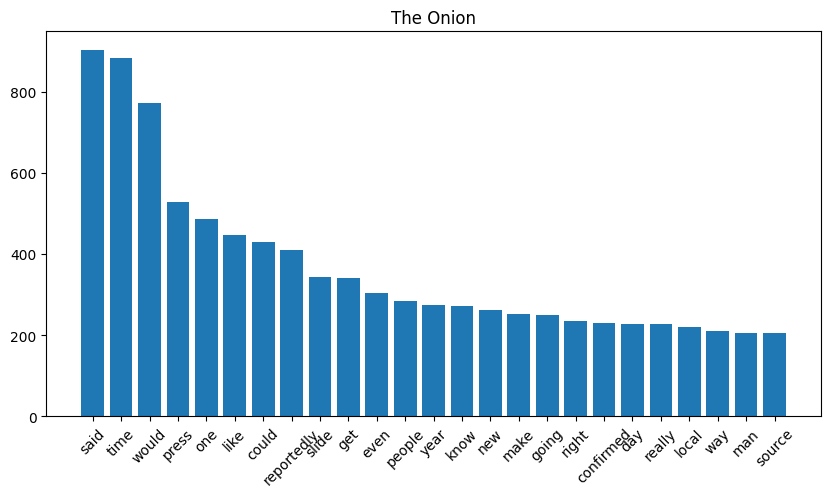

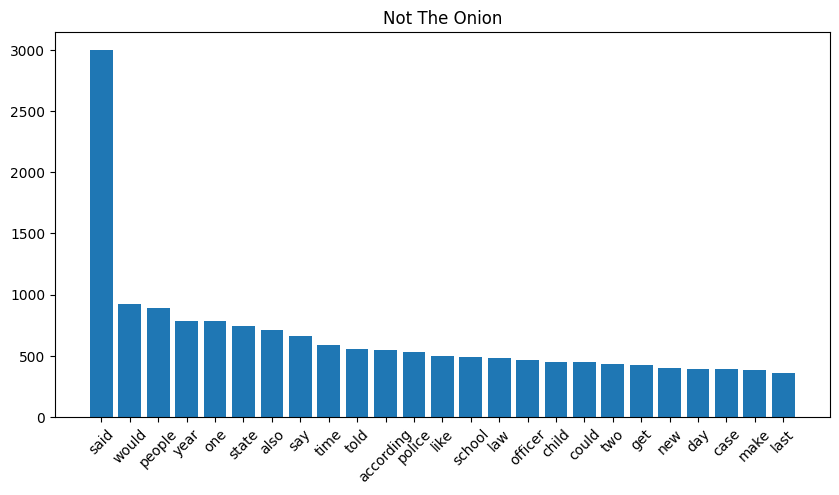

In [93]:
# onion
onion = clean_articles.loc[clean_articles['subreddit'] == 'TheOnion']
onion_word_counts = onion['word_counts'].sum()
plot_words(onion_word_counts, 'The Onion')

# nottheonion

nottheonion = clean_articles.loc[clean_articles['subreddit'] == 'nottheonion']
nottheonion_word_counts = nottheonion['word_counts'].sum()
plot_words(nottheonion_word_counts, 'Not The Onion')

In [112]:
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.model_selection import GridSearchCV

def classify_text(text, train_data, model_path):
    '''
    Classify a string of text as 'onion' or 'nottheonion' using a Decision Tree model with caching and hyperparameter tuning.

    Args:
    - text: a string of text to classify
    - train_data: a DataFrame with columns 'subreddit' and 'word_count', where 'word_count' is a Counter object with word counts
    - model_path: a string representing the path to the cached model

    Returns:
    - a string representing the predicted subreddit ('onion' or 'nottheonion')
    '''

    try:
        # load the cached model
        pipeline = joblib.load(model_path)
    except:
        # create pipeline with DictVectorizer and DecisionTreeClassifier
        pipeline = make_pipeline(DictVectorizer(), DecisionTreeClassifier())

        # define hyperparameters to tune
        hyperparameters = {
            'decisiontreeclassifier__max_depth': [5, 10, 15],
            'decisiontreeclassifier__min_samples_split': [2, 5, 10],
            'decisiontreeclassifier__min_samples_leaf': [1, 2, 4]
        }

        # create grid search object
        grid_search = GridSearchCV(pipeline, hyperparameters, cv=5)

        # train the model using grid search
        grid_search.fit(train_data['word_counts'], train_data['subreddit'])

        # save the trained model
        joblib.dump(grid_search.best_estimator_, model_path)

    # predict the subreddit of the new text
    word_count = Counter(text.split())
    DictVectorizer().fit_transform(word_count)
    prediction = pipeline.predict([word_count])

    return prediction[0]


<Axes: >

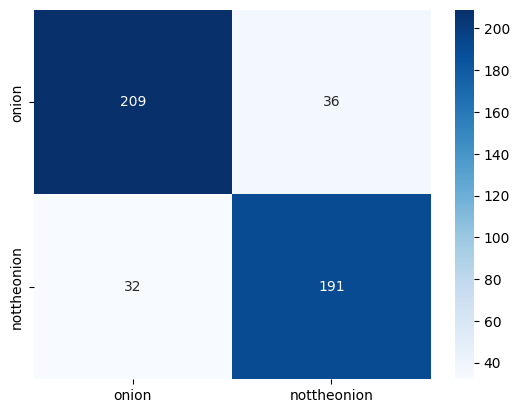

In [113]:
# test the function on the dataset and visualize the results
from sklearn.metrics import confusion_matrix
import seaborn as sns

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(articles[['text']], articles['subreddit'], test_size=0.3)

# run the model and visualize the results
y_pred = X_test['text'].map(lambda x: classify_text(x, clean_articles, 'model.pkl'))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['onion', 'nottheonion'], yticklabels=['onion', 'nottheonion'])